In [1]:
%conda list

# packages in environment at /Users/alechay/opt/anaconda3/envs/biof399-fp:
#
# Name                    Version                   Build  Channel
_tflow_select             2.3.0                       mkl  
absl-py                   0.11.0             pyhd3eb1b0_1  
appnope                   0.1.2           py37hecd8cb5_1001  
astor                     0.8.1            py37hecd8cb5_0  
backcall                  0.2.0              pyhd3eb1b0_0  
blas                      1.0                         mkl  
c-ares                    1.17.1               h9ed2024_0  
ca-certificates           2021.1.19            hecd8cb5_0  
certifi                   2020.12.5        py37hecd8cb5_0  
coverage                  5.5              py37h9ed2024_2  
cycler                    0.10.0                   py37_0  
cython                    0.29.22          py37h23ab428_0  
decorator                 4.4.2              pyhd3eb1b0_0  
et_xmlfile                1.0.1                   py_1001    anaconda
free

# Classifiying MRI Data as Demented or Nondemented

Load Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nibabel as nib # For reading image files
import tensorflow as tf 

import os

Load Data

In [3]:
df = pd.read_excel('data/oasis_longitudinal_demographics.xlsx')
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1986.550000,0.696106,0.883440
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004.479526,0.681062,0.875539
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678.290000,0.736336,1.045710
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1737.620000,0.713402,1.010000
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1697.911134,0.701236,1.033623


In [4]:
print(df.shape)
df['Group'].value_counts()

(373, 15)


Nondemented    190
Demented       146
Converted       37
Name: Group, dtype: int64

Exclude where group is 'Converted'. The goal is just to classify demented vs nondemented images. The 'Converted' label is confusing because we don't know which of those subject's scans were classified as demented and which were nondemented. <br>
To also only include each subject's first scan: `df['MRI ID'].str.endswith('MR1')`

In [5]:
subjects = df[(df['Group']!='Converted')]
subjects = subjects[['Subject ID', 'MRI ID', 'Group']]
print(subjects.shape)
subjects['Group'].value_counts()

(336, 3)


Nondemented    190
Demented       146
Name: Group, dtype: int64

## Individual subject load

In [6]:
test = nib.load('data/OAS2_RAW/OAS2_0001_MR1/RAW/mpr-1.nifti.hdr')

In [7]:
img_data = test.get_fdata()
print(img_data.shape)
print(img_data.dtype)

(256, 256, 128, 1)
float64


Visualize images

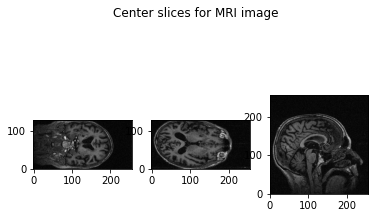

In [8]:
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

slice_0 = img_data[127, :, :, 0]
slice_1 = img_data[:, 127, :, 0]
slice_2 = img_data[:, :, 63, 0]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for MRI image") ;

## Load scans for all subjects

In [9]:
subjects.head()

,Subject ID,MRI ID,Group
0,OAS2_0001,OAS2_0001_MR1,Nondemented
1,OAS2_0001,OAS2_0001_MR2,Nondemented
2,OAS2_0002,OAS2_0002_MR1,Demented
3,OAS2_0002,OAS2_0002_MR2,Demented
4,OAS2_0002,OAS2_0002_MR3,Demented


In [10]:
images = []
mri_id = []

for s in subjects['MRI ID']:
    d = os.path.join('data/OAS2_RAW', s, 'RAW')
    
    for file in os.listdir(d):
        if file.endswith(".hdr"):
            file = os.path.join(d, file)
            images.append(nib.load(file))
            mri_id.append(s)

assert(len(images) == len(mri_id))

image_df = pd.DataFrame(list(zip(mri_id, images)), columns =['MRI ID', 'Image'])

In [11]:
subjects = subjects.merge(image_df, how='right', on='MRI ID')
assert(subjects['Image'].isnull().values.any()==False)
print(subjects.shape)
subjects[subjects['Subject ID'] == 'OAS2_0001']

(1234, 4)


,Subject ID,MRI ID,Group,Image
0,OAS2_0001,OAS2_0001_MR1,Nondemented,<class 'nibabel.nifti1.Nifti1Pair'>\ndata shap...
1,OAS2_0001,OAS2_0001_MR1,Nondemented,<class 'nibabel.nifti1.Nifti1Pair'>\ndata shap...
2,OAS2_0001,OAS2_0001_MR1,Nondemented,<class 'nibabel.nifti1.Nifti1Pair'>\ndata shap...
3,OAS2_0001,OAS2_0001_MR2,Nondemented,<class 'nibabel.nifti1.Nifti1Pair'>\ndata shap...
4,OAS2_0001,OAS2_0001_MR2,Nondemented,<class 'nibabel.nifti1.Nifti1Pair'>\ndata shap...
5,OAS2_0001,OAS2_0001_MR2,Nondemented,<class 'nibabel.nifti1.Nifti1Pair'>\ndata shap...
